# TreeCorr Explorer 4 #
In this notebook, we need to first figure out how to use patch center, then run the clustering code in pz bins across different magnitude bins to confirm the clustering signal.

In [1]:
from __future__ import print_function
from astropy.io import fits
import numpy as np
import pandas as pd
import treecorr
import time
import pprint
import matplotlib
from matplotlib import pyplot as plt
from astropy.table import Table
%matplotlib inline

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
# My own adds to Carles' rcParams updates
#plt.rcParams.update({'lines.markersize': 8}) 6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})

## Defined functions ##

In [3]:
def label_generator(r):
    '''
    Given a list or array r, returns range labels in the form of list.
    The last item in r is ignored with the last item in labels being
    (the secong last item in r - )
    '''
    labels = []
    s = '{:0.1f}-{:0.1f}'
    for i in range(len(r)-1):
        if (i == len(r)-2):
            labels.append('{}-'.format(r[i]))
        else:
            labels.append(s.format(r[i], r[i+1]))
    return labels

In [4]:
def patch_center_generator(seed_df, n, name):
    '''
    Generate the cen_file from a seed galaxy catalog and the number of patched.
    seed_df: pd dataframe. seed_cat should span the same space for all relevant 
             calculations, maybe the rand catalog would be ideal;
    n: int. n ~ (number of theta bins)^(3/2);
    name: name of the file containing center info.
    '''
    ra = seed_df.ra
    dec = seed_df.dec
    seed_cat = treecorr.Catalog(ra=ra, dec=dec, npatch=n, 
                                ra_units='degrees', dec_units='degrees')
    seed_cat.write_patch_centers(name)
    return name

In [5]:
gg = treecorr.GGCorrelation(min_sep=1, max_sep=400, 
                            nbins=10, sep_units='arcmin', var_method='jackknife')

In [6]:
dd = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [7]:
rr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [8]:
dr = treecorr.NNCorrelation(min_sep=0.1, max_sep=100, 
                            bin_size=0.2, sep_units='arcmin', var_method='jackknife')

In [9]:
ng = treecorr.NGCorrelation(min_sep=0.1, max_sep=100, 
                            nbins=10, sep_units='arcmin', var_method='jackknife')

In [10]:
def plot_gg(data, labels, figsize, cen_file):
    ''' Takes in galaxy data and pz_labels to plot shear-shear correlation.
        data: pd dataframe
        labels: list
        figsize: list of two length elements
        cen_file: str of file containg patch centers
    '''
    figs, axes = plt.subplots(len(labels), 1, sharex=True, figsize = figsize)
    for i in range(len(labels)):
        mask = data.pz_group == labels[i]
        ra = data[mask].ira
        dec = data[mask].idec
        g1 = data[mask].ishape_hsm_regauss_e1
        g2 = data[mask].ishape_hsm_regauss_e2
        cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, 
                               ra_units='degrees', dec_units='degrees', 
                               patch_centers=cen_file)
        gg.process(cat)
        r = np.exp(gg.meanlogr)
        xip = gg.xip
        xim = gg.xim
        sig = np.sqrt(gg.varxip)
        
        axes[i].plot(r, xip, color='blue')
        axes[i].plot(r, -xip, color='blue', ls=':')
        axes[i].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], color='blue', lw=0.1, ls='')
        axes[i].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], color='blue', lw=0.1, ls='')
        lp = axes[i].errorbar(-r, xip, yerr=sig, color='blue')
        
        axes[i].plot(r, xim, color='green')
        axes[i].plot(r, -xim, color='green', ls=':')
        axes[i].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
        axes[i].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
        lm = axes[i].errorbar(-r, xim, yerr=sig, color='green')
        
        axes[i].set_xscale('log')
        axes[i].set_yscale('log', nonposy='clip')
        if (i == len(labels)-1):
            axes[i].set_xlabel(r'$\theta$ (arcmin)')
        axes[i].set_title('z={}'.format(labels[i]))
        axes[i].legend([lp, lm], [r'$\xi_+(\theta)$', r'$\xi_-(\theta)$'])
        axes[i].set_xlim( [1,200] )
        axes[i].set_ylabel(r'$\xi_{+,-}$')
        
    plt.show()

In [11]:
def plot_ng(data, labels, figsize, cen_file):
    ''' ng correlation needs a source and lens catalog of which 
        z_source > z_lens. Function returns a plot of gamma_t for the 
        respective lens and source bins.
        data: pd dataframe
        labels: list
        figsize: list of two length elements
        cen_file: str of file containg patch centers
    '''
    # Find out how to add a set of master axes for source and lens z
    n = len(labels)
    figs, axes = plt.subplots(n, n, sharex=False, figsize = figsize)
    # i iterate through z_source, row data
    # j iterate through z_lens, col data
    # Make sure that i and j iterate through the same things
    for i in range(n):
        smask = data.pz_group == labels[i]
        sra = data[smask].ira
        sdec = data[smask].idec
        sg1 = data[smask].ishape_hsm_regauss_e1
        sg2 = data[smask].ishape_hsm_regauss_e2
        sw = data[smask].ishape_hsm_regauss_derived_shape_weight
        scat = treecorr.Catalog(ra=sra, dec=sdec, g1=sg1, g2=sg2, w=sw,  
                                ra_units='degrees', dec_units='degrees', 
                                patch_centers=cen_file)
        for j in range(n):
            if (i > j):
                lmask = data.pz_group == labels[j]
                lra = data[lmask].ira
                ldec = data[lmask].idec
                lg1 = data[lmask].ishape_hsm_regauss_e1
                lg2 = data[lmask].ishape_hsm_regauss_e2
                lw = data[lmask].ishape_hsm_regauss_derived_shape_weight
                lcat = treecorr.Catalog(ra=lra, dec=ldec, g1=lg1, g2=lg2, w=lw,
                                        ra_units='degrees', dec_units='degrees', 
                                        patch_centers=cen_file)

                ng.process(lcat, scat)
                r = np.exp(ng.meanlogr)
                xip = ng.xi
                xim = ng.xi_im
                sig = np.sqrt(ng.varxi)

                axes[i, j].scatter(r, xip, color='blue')
                axes[i, j].scatter(r, -xip, color='lightblue', ls=':')
                axes[i, j].errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], 
                                    color='blue', lw=0.1, ls='')
                axes[i, j].errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], 
                                    color='blue', lw=0.1, ls='')
                lp = axes[i, j].errorbar(-r, xip, yerr=sig, color='blue')

                #axes[i, j].plot(r, xim, color='green')
                #axes[i, j].plot(r, -xim, color='green', ls=':')
                #axes[i, j].errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
                #axes[i, j].errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
                #lm = axes[i, j].errorbar(-r, xim, yerr=sig, color='green')
        
                axes[i, j].set_xscale('log')
                axes[i, j].set_yscale('log', nonposy='clip')
                #if (i == len(labels)-1):
                #    axes[i].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_title(r'$z_s:{}$, $z_l:{}$'.format(labels[i], labels[j]))
                axes[i, j].legend([lp], [r'$\xi_{Re}(\theta)$'])
                #axes[i, j].set_xlim( [1, 50] )
                axes[i, j].set_xlabel(r'$\theta$ (arcmin)')
                axes[i, j].set_ylabel(r'$\xi_{Re}$')
            else:
                axes[i, j].set_axis_off()
        
    plt.show()

In [12]:
def plot_dr_pz(data, random, labels, figsize, cen_file):
    ''' Takes in galaxy data, random catalog and pz_labels to plot 
        data-random correlation (clustering signal) in pz_bins.
        data: pd dataframe
        random: pd dataframe
        labels: list
        figsize: list of two length elements
        cen_file: str of file containg patch centers
    '''
    figs, axes = plt.subplots(1, 1, sharex=True, figsize = figsize)
    
    # Random catalog data
    rra = random.ra
    rdec = random.dec       
    rand = treecorr.Catalog(ra=rra, dec=rdec, 
                            ra_units='degrees', dec_units='degrees', 
                            patch_centers=cen_file)
    
    for i in range(len(labels)):
        # Generate catalog
        mask = data.pz_group == labels[i]        
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight        
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, 
                               ra_units='degrees', dec_units='degrees', 
                               patch_centers=cen_file)
        
        # Process catalog
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        axes.plot(r, xi, color=colorwheel[i], label='pz:{}'.format(labels[i]))
        axes.plot(r, -xi, color=colorwheel[i], ls=':')
        axes.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes.errorbar(-r, xi, yerr=sig, color=colorwheel[i])
        
    axes.set_title('Clustering in pz bins')    
    axes.set_xscale('log')
    axes.set_yscale('log', nonposy='clip')
    axes.set_xlabel(r'$\theta$ (arcmin)')
    axes.legend()
        
    plt.show()

In [13]:
def plot_dr_mag(data, random, pz, labels, figsize, pz_bins, cen_file):
    ''' Takes in galaxy data, random, pz catalog and mag_labels to plot 
        data-random correlation in i-mag bins.
        data: pd dataframe
        random: pd dataframe
        pz: pd dataframe
        labels: list
        figsize: list of two length elements
        pz_bins: int of the number of bins for pz histogram
        cen_file: str of file containg patch centers
    '''
    figs, axes = plt.subplots(1, 2, figsize = figsize)
    # Initiate two subplots where one is the clustering signal and the other
    # is the histogram of pz for rhe respective imag bin galaxies
    
    # Random catalog data since it only needs to be run once
    rra = random.ra
    rdec = random.dec       
    rand = treecorr.Catalog(ra=rra, dec=rdec, 
                            ra_units='degrees', dec_units='degrees', 
                            patch_centers=cen_file)
    
    for i in range(len(labels)):
        mask = data.mag_group == labels[i]
        
        # Catalog data
        cra = data[mask].ira
        cdec = data[mask].idec
        cg1 = data[mask].ishape_hsm_regauss_e1
        cg2 = data[mask].ishape_hsm_regauss_e2
        cw = data[mask].ishape_hsm_regauss_derived_shape_weight
        cat = treecorr.Catalog(ra=cra, dec=cdec, g1=cg1, g2=cg2, w=cw, 
                               ra_units='degrees', dec_units='degrees', 
                               patch_centers=cen_file)
        
        # Pz catalog data 
        photoz = pz[mask].ephor_photoz_best
        
        # Processing the catalogs
        dd.process(cat)
        rr.process(rand)
        dr.process(cat, rand)
        xi, varxi = dd.calculateXi(rr, dr)
        r = np.exp(dd.meanlogr)
        sig = np.sqrt(varxi)
        
        # Ploting clustering signal of different mag bins on 0-th subplot
        axes[0].plot(r, xi, color=colorwheel[i], label='i-mag:{}'.format(labels[i]))
        axes[0].plot(r, -xi, color=colorwheel[i], ls=':')
        axes[0].errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes[0].errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], 
                      color=colorwheel[i], lw=0.1, ls='')
        axes[0].errorbar(-r, xi, yerr=sig, color=colorwheel[i])
        
        # Plotting pz histogram of different mag bins on 1-th subplot 
        # using the same color scheme
        axes[1].hist(photoz, bins=pz_bins, histtype='step', linewidth=1, 
                     color=colorwheel[i], label='Total:{}'.format(len(data[mask])))
        
    axes[0].set_title('Clustering in imag bins')    
    axes[0].set_xscale('log')
    axes[0].set_yscale('log', nonposy='clip')
    axes[0].set_xlabel(r'$\theta$ (arcmin)')
    axes[0].legend(loc='lower left')
    
    axes[1].set_title('pz distribution for imag bins')
    axes[1].set_xlabel('ephor best pz')
    axes[1].set_ylabel('Number of galaxies')
    axes[1].set_yscale('log')
    axes[1].legend()
        
    plt.show()

In [14]:
colorwheel = ['blue', 'red', 'green', 'orange', 'teal', 'purple', 'cyan']

## Import data ##

In [15]:
hectomap_path = "Data/HECTOMAP_calibrated.fits"
hectomap_pz_path = "Data/HECTOMAP_pz.fits"
hectomap_rand_path = "Data/HECTOMAP_rand.fits"

In [16]:
df = Table.read(hectomap_path, format='fits').to_pandas()
pz_df = Table.read(hectomap_pz_path, format='fits').to_pandas()
rand_df = Table.read(hectomap_rand_path, format='fits').to_pandas()

In [17]:
centers = patch_center_generator(rand_df, 30, 'cen_file_30')

## Enforce pz and i-band magnitude cuts ##

In [18]:
pz_range = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 100])
pz_labels = label_generator(pz_range)

In [19]:
df['pz_group'] = pd.cut(pz_df.ephor_photoz_best, pz_range, right=False, labels=pz_labels)

In [20]:
mag_range = np.array([17, 18, 19, 20, 21, 22, 23, 100])
mag_labels = label_generator(mag_range)

In [21]:
df['mag_group'] = pd.cut(df.imag_cmodel, mag_range, right=False, labels=mag_labels)

In [22]:
imag_mask = df.imag_cmodel <= 23
df_imag_masked = df[imag_mask]
pz_df_imag_masked = pz_df[imag_mask]

In [23]:
pz_mask = pz_df_imag_masked.ephor_photoz_best <= 1.5
df_imag_pz_masked = df_imag_masked[pz_mask]
pz_df_imag_pz_masked = pz_df_imag_masked[pz_mask]

## Plotting ##

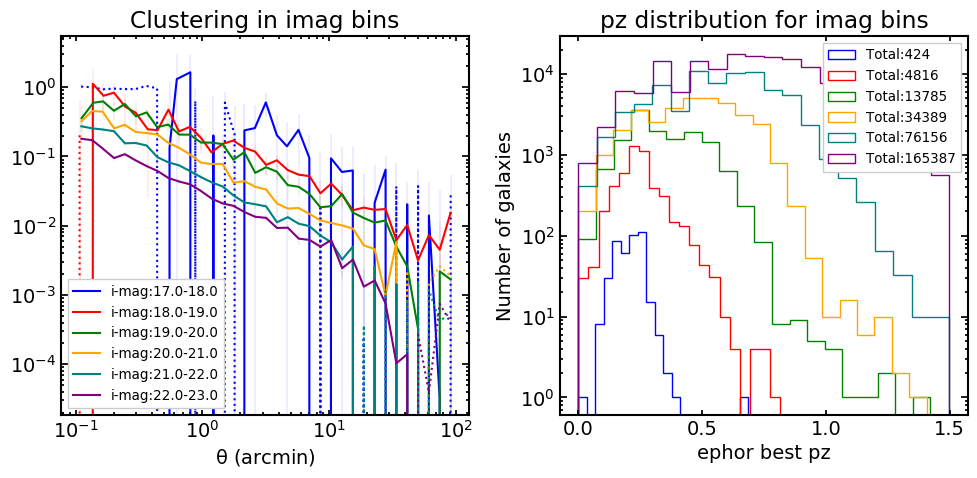

In [26]:
plot_dr_mag(df_imag_pz_masked, rand_df, pz_df_imag_pz_masked, mag_labels[:-1], [10, 5], 20, centers)

Just to test, what would be the difference between same seed for all and just same seed for a pair?